In [1]:
from model import Gmail
import matplotlib.pyplot as plt
import numpy as np
import random
from hash import Hasher

In [2]:
G = Gmail()

## Generating a sample dataset
This generated dataset picks 400 random messages from my inbox and 100 job application messages that were labeled from previous analysis using this software.

In [3]:
generate_sample = False
if generate_sample:
    jobs = G.labels.match(['Job Applications'])
    job_samples = random.sample(jobs, 100)

    all_msgs = G.labels.match([])
    job_ids = set([x['id'] for x in jobs])
    rand_samples = []
    while len(rand_samples) < 400:
        m = random.choice(all_msgs)
        if not m['id'] in job_ids:
            rand_samples.append(m)
    samples = job_samples + rand_samples
    for i,m in enumerate(samples):
        print(i, end='\r')
        G.labels.setLabel(m, ['Demo'])
    print('done')

In [4]:
inbox = G.labels.match(['Demo'])
jobs = G.labels.match(['Demo','Job Applications'])
not_jobs = []
for m in inbox:
    if not m in jobs:
        not_jobs.append(m)
false_negatives = G.labels.match(['Job False Negative'])

In [5]:
print('inbox:', len(inbox))
print('jobs:', len(jobs))
print('not jobs:', len(not_jobs))
print('false negatives', len(false_negatives))

inbox: 500
jobs: 100
not jobs: 400
false negatives 15


The false negative list is a small set of hand-labeled messages that were missed durring initial attempts of sorting messages

## Let's analyze the data
We will begin using only 10 messages to seed the category

In [6]:
H = Hasher(8)
for m in random.sample(jobs,10):
    content = G.messages.parseMessage(m)
    H.add(content)

In [7]:
len(H)

19851

Thats a big data structure. Once we identify more jobs, we can filter for only the most common words

## Eager learning
This structure can easily be modified as more data is processed.

In [8]:
for m in random.sample(inbox,100):
    content = G.messages.parseMessage(m)
    s = H.sim(content, .5)
    if s > .6: # If we are confident the message is part of the community, add it to the hash
        H.add(content)
print(f'Number of documents in hash: {H.n}')

Number of documents in hash: 29


In [9]:
L = len(H)
H.filter(0.1) # Filter words at least 10% common (appears in > 2 docs when hash.n = 25)
print(f'Filtered {L-len(H)} elements. {L} -> {len(H)}')

Filtered 32201 elements. 41257 -> 9056


## Testing on sample

In [10]:
def evalScores(H, messages, freq):
    scores = []
    for i,m in enumerate(messages):
        print(i,end='\r')
        content = G.messages.parseMessage(m)
        s = H.sim(content,freq)
        scores.append(s)
    print('done')
    return scores

In [11]:
freq = .3
job_scores = evalScores(H, jobs, freq)
not_scores = evalScores(H, random.sample(not_jobs,100), freq)
neg_scores = evalScores(H, false_negatives, freq)

done
done
done


(array([ 3.84615385,  0.        ,  7.69230769,  7.69230769, 11.53846154,
         7.69230769,  7.69230769,  0.        ,  7.69230769,  3.84615385]),
 array([0.14666667, 0.164     , 0.18133333, 0.19866667, 0.216     ,
        0.23333333, 0.25066667, 0.268     , 0.28533333, 0.30266667,
        0.32      ]),
 <a list of 10 Patch objects>)

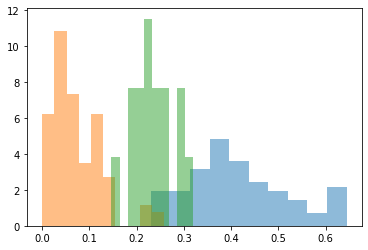

In [12]:
plt.hist(job_scores, alpha=0.5, density=True)
plt.hist(not_scores, alpha=0.5, density=True)
plt.hist(neg_scores, alpha=0.5, density=True)

## Let's make a bigger hash

In [13]:
H = Hasher(8)
for m in jobs:
    content = G.messages.parseMessage(m)
    H.add(content)

In [14]:
L = len(H)
H.filter(0.1) # Filter words at least 10% common
print(f'Filtered {L-len(H)} elements. {L} -> {len(H)}')

Filtered 95425 elements. 97391 -> 1966


done
done
done
done
done
done
done
done
done


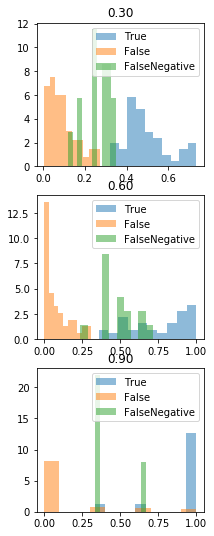

In [15]:
legend = []
sample_size = 50
SJ = random.sample(jobs, sample_size)
SNJ = random.sample(not_jobs, sample_size)
FN = false_negatives
n = 3
plt.figure(figsize=[3,9])
for i,freq in enumerate(np.linspace(.3,.9,n)):
    plt.subplot(3,1,i+1)
    scores= evalScores(H, SJ, freq)
    plt.hist(scores, alpha=0.5, density=True)
    
    scores= evalScores(H, SNJ, freq)
    plt.hist(scores, alpha=0.5, density=True)
    
    scores= evalScores(H, FN, freq)
    plt.hist(scores, alpha=0.5, density=True)
    plt.title(f'{freq:.2f}')
    plt.legend(['True','False','FalseNegative'])

In [21]:
H.countFilter(.9)

3

In [33]:
H.countFilter(.8)

13

In [34]:
for m in random.sample(not_jobs,200):
    content = G.messages.parseMessage(m)
    s = H.sim(content, .8)
    if s > .5:
        print(s, content[:500])
        print()

0.6 To view this email as a web page, go to the link below,  or copy and paste it into your browser's address window.    http://view.communications.cu.edu/?qs=0f4a144d91e32b224224d49abd1259ed2283369d3c523c43afa74c2c4976c595fb47320103674118623ba730fa8632707bc74671380c68048d8ddd799db7165ef5778243a20fccba    May 3, 2017Campus Targeted by Google Docs Phishing EmailsThe campus has recently been targeted by malicious emails that attempt to gain access to a recipient&rsquo;s Google account. The email claim

0.7 Dear Colleagues,This is a friendly reminder of the APPM Colloquium this afternoon:  *   Pre-talk for students (2:00-2:40 p.m. @ Newton Lab, ECCR 257).  *   Coffee break for everyone (2:40-3:00 p.m. @ Newton Lab, ECCR 257).  *   Colloquium (3:00-4:00 p.m. @ ECCR 245).Our speaker today is Henry Adams (Department of Mathematics, Colorado State University),with the following title and abstract:An introduction to applied topologyThis talk is an introduction to computational topology, as app

In [35]:
print(H.countFilter(.8))

13


In [36]:
H.showFilter(.8)

{'plicatio': 89,
 'applicat': 89,
 'pplicati': 89,
 ' interes': 93,
 ' applica': 92,
 'lication': 89,
 'interest': 93,
 'ur inter': 80,
 'your int': 80,
 'our inte': 80,
 ' your in': 81,
 'nterest ': 87,
 'ication ': 81}

## Current Issues

### Population Specific
If your initial sample contains 10 messages of 'CU Boulder Today' and 1 message from 'APPM Email Lists', the hash will likely only match 'CU Boulder Today' messages as content about APPM is likely < 10%.
This is especially important when eagerly learning as each new message can alter the hash function of the next message.
To resolve this issue, a new method must be implemented. Given a label contains no false positives, messages that are not very similar must be 'over represented' in the group. This is very easy to implement because of the objects eager learning capabilities.

### Bredth Limits
For categories with very diverse language, even the descriptive words may not be very common. Classifying these types of messages will require strong care with the frequency tolerances.

### API parsing issues
Emails contain some HTML to style the message. We've done our best to filter it out, but some messages have significant chunks of code. As the keywords of HTML will be the same across all categories, this will cause false matches.